In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import string

In [2]:
periods_map = {
    "The Belle Époque (1900-1914)": {"start_year": 1900, "end_year": 1914},
    "World War I (1914-1918)": {"start_year": 1914, "end_year": 1919},
    "The Roaring Twenties (1920-1929)": {"start_year": 1920, "end_year": 1929},
    "The Great Depression (1929-1939)": {"start_year": 1929, "end_year": 1939},
    "World War II (1939-1945)": {"start_year": 1939, "end_year": 1946},
    "The Cold War and McCarthyism (1947-1991)": {"start_year": 1947, "end_year": 1991},
    "The Civil Rights and Social Equality Struggles (1950s-1970s)": {"start_year": 1950, "end_year": 1970},
    "The Reagan Years and the Rise of Neoliberalism (1980s)": {"start_year": 1980, "end_year": 1989},
    "The Post-Cold War and the New World Order (1991-2001)": {"start_year": 1991, "end_year": 2001},
    "The 9/11 Attacks and the War on Terrorism (2001-present)": {"start_year": 2001, "end_year": 2024},
}

def map_year_to_periods(year, periods):
    matching_periods = []
    for period, years in periods.items():
        if years['start_year'] <= year <= years['end_year']:
            matching_periods.append(period)
    if matching_periods:
        return matching_periods
    else:
        return ["Year not in any defined period"]
    
# Sort the periods based on their start year
sorted_periods = sorted(periods_map.items(), key=lambda x: x[1]['start_year'])
# Create a mapping from period name to its position in the timeline
period_order_map = {period[0]: idx for idx, period in enumerate(sorted_periods)}

periods_events_map = {
    "The Belle Époque (1900-1914)": [
        "third Great Awakening", 
        "economic prosperity", 
        "segregation"
    ],
    "World War I (1914-1918)": [
        "segregation", 
        "1st world war"
    ],
    "The Roaring Twenties (1920-1929)": [
        "economic euphoria", 
        "industrial expansion", 
        "cultural change", 
        "rise of women's rights", 
        "stock market boom", 
        "prohibition"
    ],
    "The Great Depression (1929-1939)": [
        "1929 stock market crash", 
        "mass unemployment", 
        "New Deal reforms"
    ],
    "World War II (1939-1945)": [
        "military production recovery", 
        "U.S. contribution to Allies", 
        "new technologies", 
        "United Nations"
    ],
    "The Cold War and McCarthyism (1947-1991)": [
        "capitalist vs communist blocs", 
        "internal political repression", 
        "Korean War", 
        "Cuban Missile Crisis", 
        "Vietnam War", 
        "space race"
    ],
    "The Civil Rights and Social Equality Struggles (1950s-1970s)": [
        "civil rights movements", 
        "Martin Luther King Jr.", 
        "Civil Rights Act", 
        "Voting Rights Act", 
        "women’s and LGBTQ+ rights"
    ],
    "The Reagan Years and the Rise of Neoliberalism (1980s)": [
        "conservative shift", 
        "deregulation", 
        "tax cuts", 
        "War on drugs", 
        "arms race", 
        "new technologies"
    ],
    "The Post-Cold War and the New World Order (1991-2001)": [
        "fall of the Soviet Union", 
        "technological advancements", 
        "Gulf War", 
        "internet development", 
        "1990s economic boom"
    ],
    "The 9/11 Attacks and the War on Terrorism (2001-present)": [
        "9/11 attacks", 
        "War on Terror", 
        "Patriot Act", 
        "Iraq War", 
        "2008 financial crisis", 
        "geopolitical tensions"
    ]
}

dataframes column'names are taken from the `README.md` file in the dataset

In [240]:
# display full numbers separated with spaces instead of scientific notation
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x).replace(",", " "))
pd.reset_option('display.float_format')

## Characters

In [241]:
characters_df = pd.read_csv("MovieSummaries/character.metadata.tsv", delimiter="\t", header=None)
#characters_df = pd.read_csv("MovieSummaries/processed_characters.csv", delimiter="\t", header=None)
characters_df.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"]

In [242]:
characters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia movie ID               450669 non-null  int64  
 1   Freebase movie ID                450669 non-null  object 
 2   Movie release date               440674 non-null  object 
 3   Character name                   192794 non-null  object 
 4   Actor date of birth              344524 non-null  object 
 5   Actor gender                     405060 non-null  object 
 6   Actor height (in meters)         154824 non-null  float64
 7   Actor ethnicity (Freebase ID)    106058 non-null  object 
 8   Actor name                       449441 non-null  object 
 9   Actor age at movie release       292556 non-null  float64
 10  Freebase character/actor map ID  450669 non-null  object 
 11  Freebase character ID            192804 non-null  object 
 12  Fr

In [243]:
characters_df.describe()

,Wikipedia movie ID,Actor height (in meters),Actor age at movie release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [244]:
print("percentage of NaNs per columns")
characters_df.isna().mean() * 100

percentage of NaNs per columns


Wikipedia movie ID                  0.000000
Freebase movie ID                   0.000000
Movie release date                  2.217814
Character name                     57.220488
Actor date of birth                23.552763
Actor gender                       10.120288
Actor height (in meters)           65.645740
Actor ethnicity (Freebase ID)      76.466542
Actor name                          0.272484
Actor age at movie release         35.084064
Freebase character/actor map ID     0.000000
Freebase character ID              57.218269
Freebase actor ID                   0.180842
dtype: float64

In [245]:
characters_df.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
174797,19174486,/m/04lg84h,1964-10-02,Aide,NaN,M,NaN,NaN,Desmond Davies,NaN,/m/0n4kb5t,/m/0n4kb5x,/m/0n4kb63
16559,187086,/m/019l4g,1950-05-19,NaN,1871-05-17,F,NaN,NaN,Gertrude Hoffman,NaN,/m/03jrk4v,NaN,/m/08w90c
205906,3402751,/m/099pc4,1934,NaN,NaN,NaN,NaN,NaN,William Woods,NaN,/m/05bdsc2,NaN,/m/05bdsc5
239863,2059591,/m/06j7kh,2001-06-08,NaN,NaN,M,NaN,NaN,Nigel Shawn Williams,NaN,/m/0j_52c,NaN,/m/0j_50_
253276,23151276,/m/064kvss,1956-03,NaN,1912-02-07,M,NaN,NaN,Derek Farr,NaN,/m/0hvrnzj,NaN,/m/064l6hd
417085,2982138,/m/08hlhh,2001,NaN,1955-04-23,F,1.65,NaN,Judy Davis,45.0,/m/02t9_km,NaN,/m/01jmv8
410504,6057891,/m/0fmyt9,1956-10-26,Congressman Hardison,NaN,M,NaN,NaN,Wilfred Knapp,NaN,/m/0kp95r0,/m/0kp95r3,/m/0kp95rb
275507,27491670,/m/0b__rrt,2009,Student/Angel,NaN,M,NaN,NaN,Wyatt Fenner,NaN,/m/0b_hj2j,/m/0b_hj1t,/m/0b_hj1q
443008,4538118,/m/0c7srr,1981,NaN,1925-10-23,M,NaN,NaN,Kwan Hoi San,55.0,/m/0k3545,NaN,/m/05zywwf
170607,4532642,/m/0c7j26,1996-01,Amelia,1959-03-23,F,1.73,/m/03bkbh,Catherine Keener,NaN,/m/0k7vk1,/m/0h2nfz3,/m/04bdxl


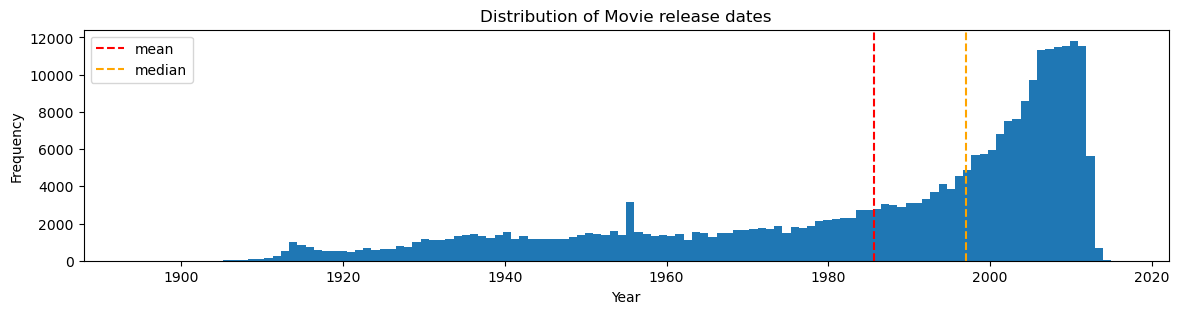

In [246]:
movie_dates = pd.to_datetime(characters_df['Movie release date'], errors='coerce').dt.year
plt.figure(figsize=(14,3))
plt.hist(movie_dates, bins=2020-1900)  
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Movie release dates')
plt.axvline(movie_dates.mean(), linestyle="--", color="red", label="mean")
plt.axvline(movie_dates.median(), color="orange", label="median", linestyle="--")
plt.legend()
plt.show()

<Axes: title={'center': 'Actor age at movie release'}, xlabel='Age', ylabel='Frequency'>

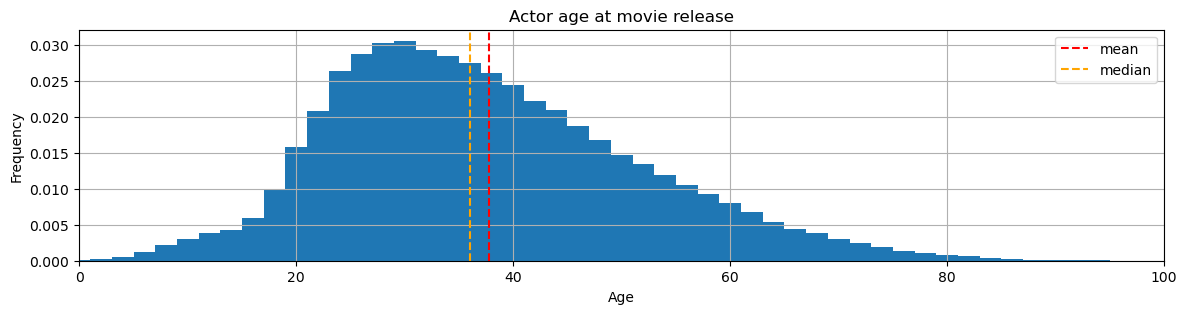

In [247]:
plt.figure(figsize=(14,3))
plt.title("Actor age at movie release")
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.axvline(characters_df["Actor age at movie release"].mean(), linestyle="--", color="red", label="mean")
plt.axvline(characters_df["Actor age at movie release"].median(), color="orange", label="median", linestyle="--")
plt.legend()
characters_df["Actor age at movie release"].hist(bins=4000, density=True)

In [248]:
"""
actor_dates = pd.to_datetime(characters_df['Actor date of birth'], errors='coerce').dt.year


plt.figure(figsize=(8,3))
plt.hist(actor_dates, bins=50)  
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Actor date of birth')
plt.show()
"""

"\nactor_dates = pd.to_datetime(characters_df['Actor date of birth'], errors='coerce').dt.year\n\n\nplt.figure(figsize=(8,3))\nplt.hist(actor_dates, bins=50)  \nplt.xlabel('Year')\nplt.ylabel('Frequency')\nplt.title('Distribution of Actor date of birth')\nplt.show()\n"

<Axes: xlabel='Actor gender', ylabel='number'>

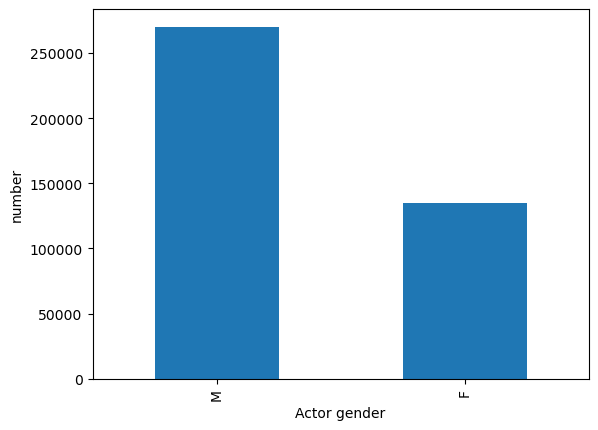

In [249]:
plt.xlabel("gender")
plt.ylabel("number")
characters_df["Actor gender"].value_counts().plot(kind="bar")

# Movies

## Genres

In [3]:
# These genre are not very relevant of the content of the movie
unwanted_genres = ['Silent film', 'Short Film']

Filter the movies dataset. We only keep the movies released after 1900 and from the USA.

In [4]:
movies_df = pd.read_csv("MovieSummaries/processed_movies.csv")

movies_df['Period'] = movies_df['Movie release date'].apply(map_year_to_periods, periods=periods_map)

#movies_df.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie box office revenue", "Movie runtime", "Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie genres (Freebase ID:name tuples)"]

movies_df['Period'].head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'MovieSummaries/processed_movies.csv'

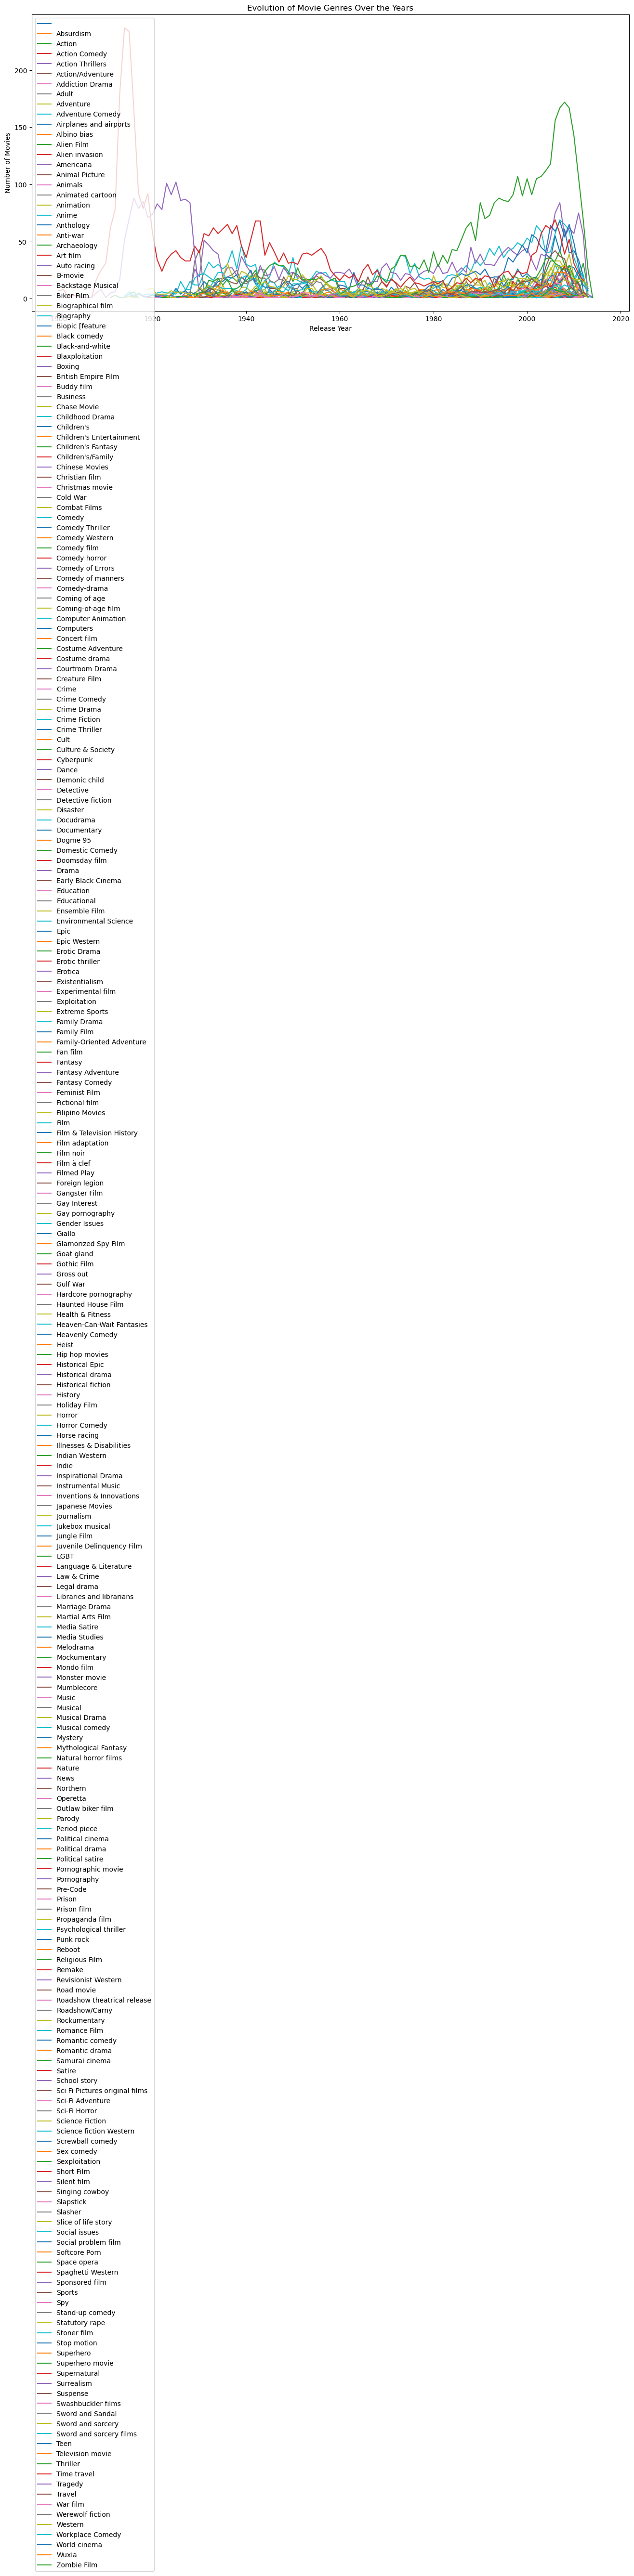

In [283]:
movies_2df = movies_df.copy()

# Define a function to extract the genre from a string
def extract_genre(genres):
    # Split the string into a list of genres
    genres_list = genres.split(',')
    # Remove leading and trailing whitespace and punctuation from the first genre string
    genre = genres_list[0].strip(string.punctuation + string.whitespace)
    # Return the cleaned genre string
    return genre

# Apply the function to the 'genres' column
movies_2df['Movie genres'] = movies_2df['Movie genres'].apply(extract_genre)

# Group the movies by genre and release year, and count the number of movies in each group
genre_counts = movies_2df.groupby(['Movie genres', 'Movie release date']).size().reset_index(name='count')

# Pivot the table so that each genre has its own column
genre_counts_pivot = genre_counts.pivot(index='Movie release date', columns='Movie genres', values='count')

# Plot the number of movies in each genre for each year
plt.figure(figsize=(16,8))
plt.plot(genre_counts_pivot)
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Evolution of Movie Genres Over the Years')
plt.legend(genre_counts_pivot.columns)
plt.show()


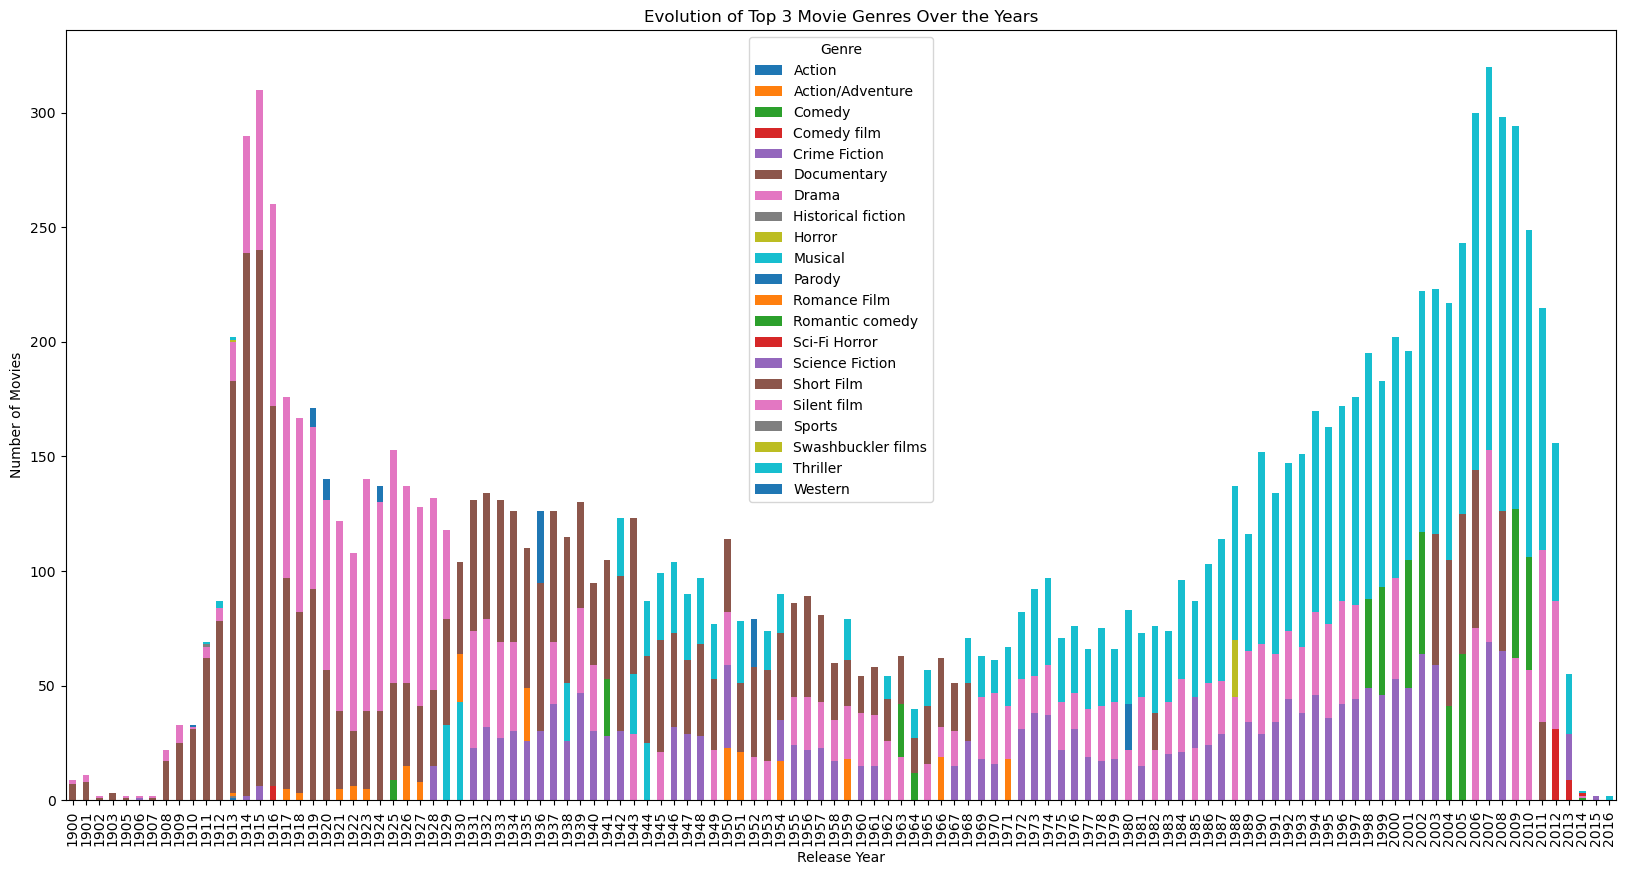

In [284]:
# Select the three most popular genres for each year
top_genres = genre_counts_pivot.rank(axis=1, ascending=False, method='min') <= 3

# Filter the DataFrame to only include the top genres
genre_counts_top = genre_counts_pivot.where(top_genres)

# Drop any columns that are all NaN (i.e., genres that were not in the top three for any year)
genre_counts_top = genre_counts_top.dropna(axis=1, how='all')

# Plot the stacked bar chart
genre_counts_top.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Evolution of Top 3 Movie Genres Over the Years')
plt.legend(title='Genre')
plt.xticks(rotation=90)
plt.show()


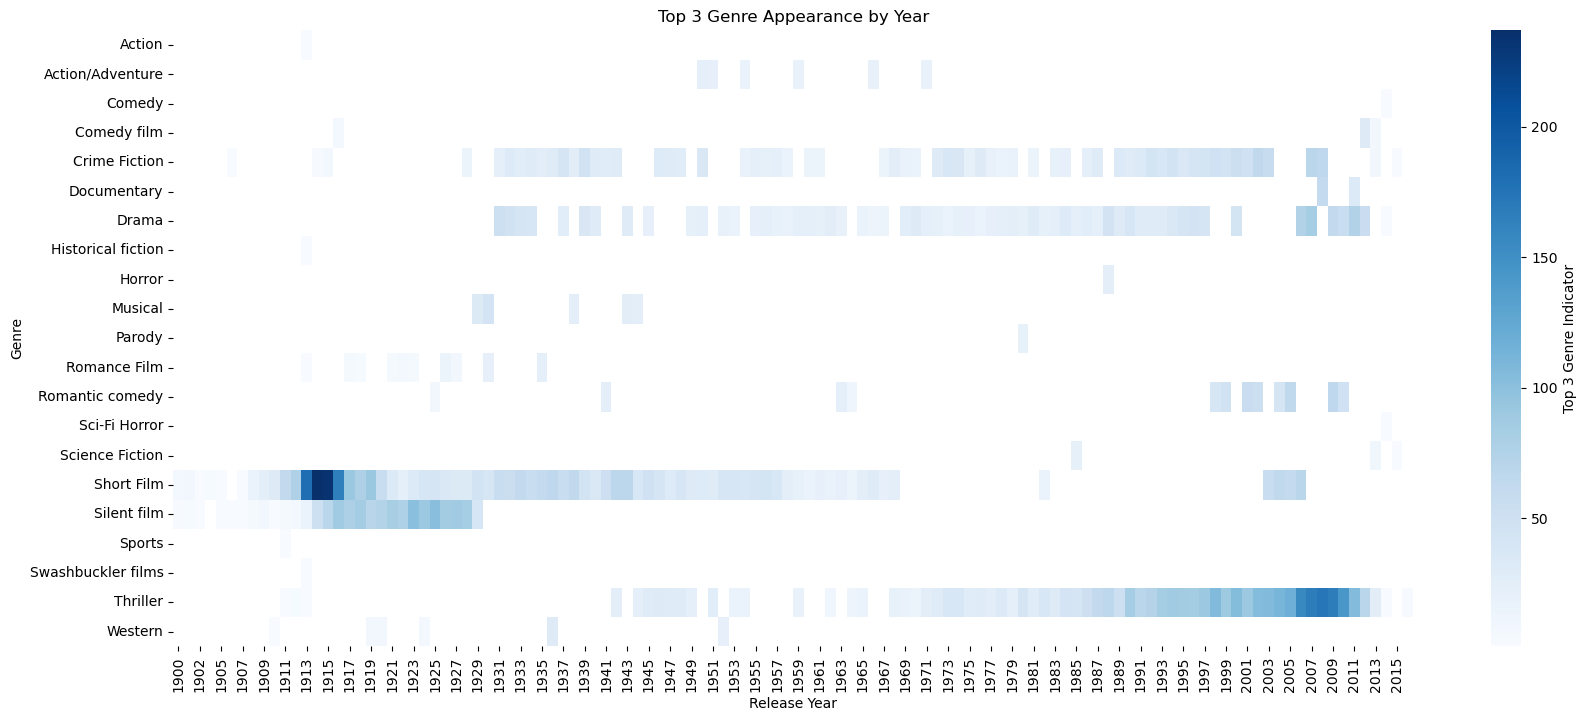

In [292]:
# Plot a heatmap showing top 3 genre appearances across years
plt.figure(figsize=(20, 8))
sns.heatmap(genre_counts_top.T, cmap="Blues", cbar_kws={'label': 'Top 3 Genre Indicator'})
plt.xlabel("Release Year")
plt.ylabel("Genre")
plt.title("Top 3 Genre Appearance by Year")
plt.show()

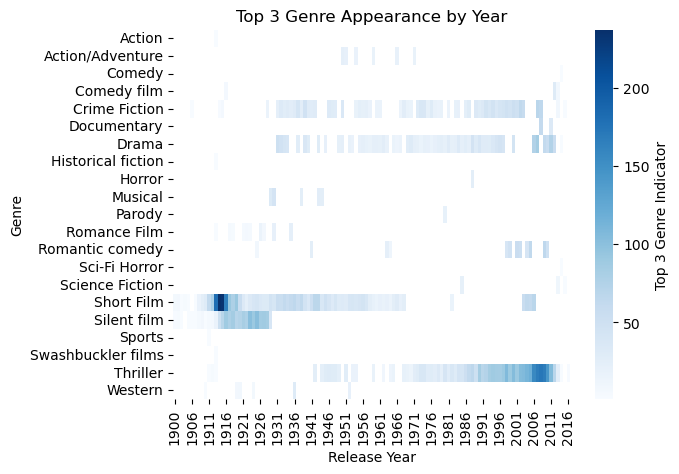

In [293]:
sns.heatmap(genre_counts_top.T, cmap="Blues", cbar_kws={'label': 'Top 3 Genre Indicator'})
plt.xlabel("Release Year")
plt.ylabel("Genre")
plt.title("Top 3 Genre Appearance by Year")
plt.show()

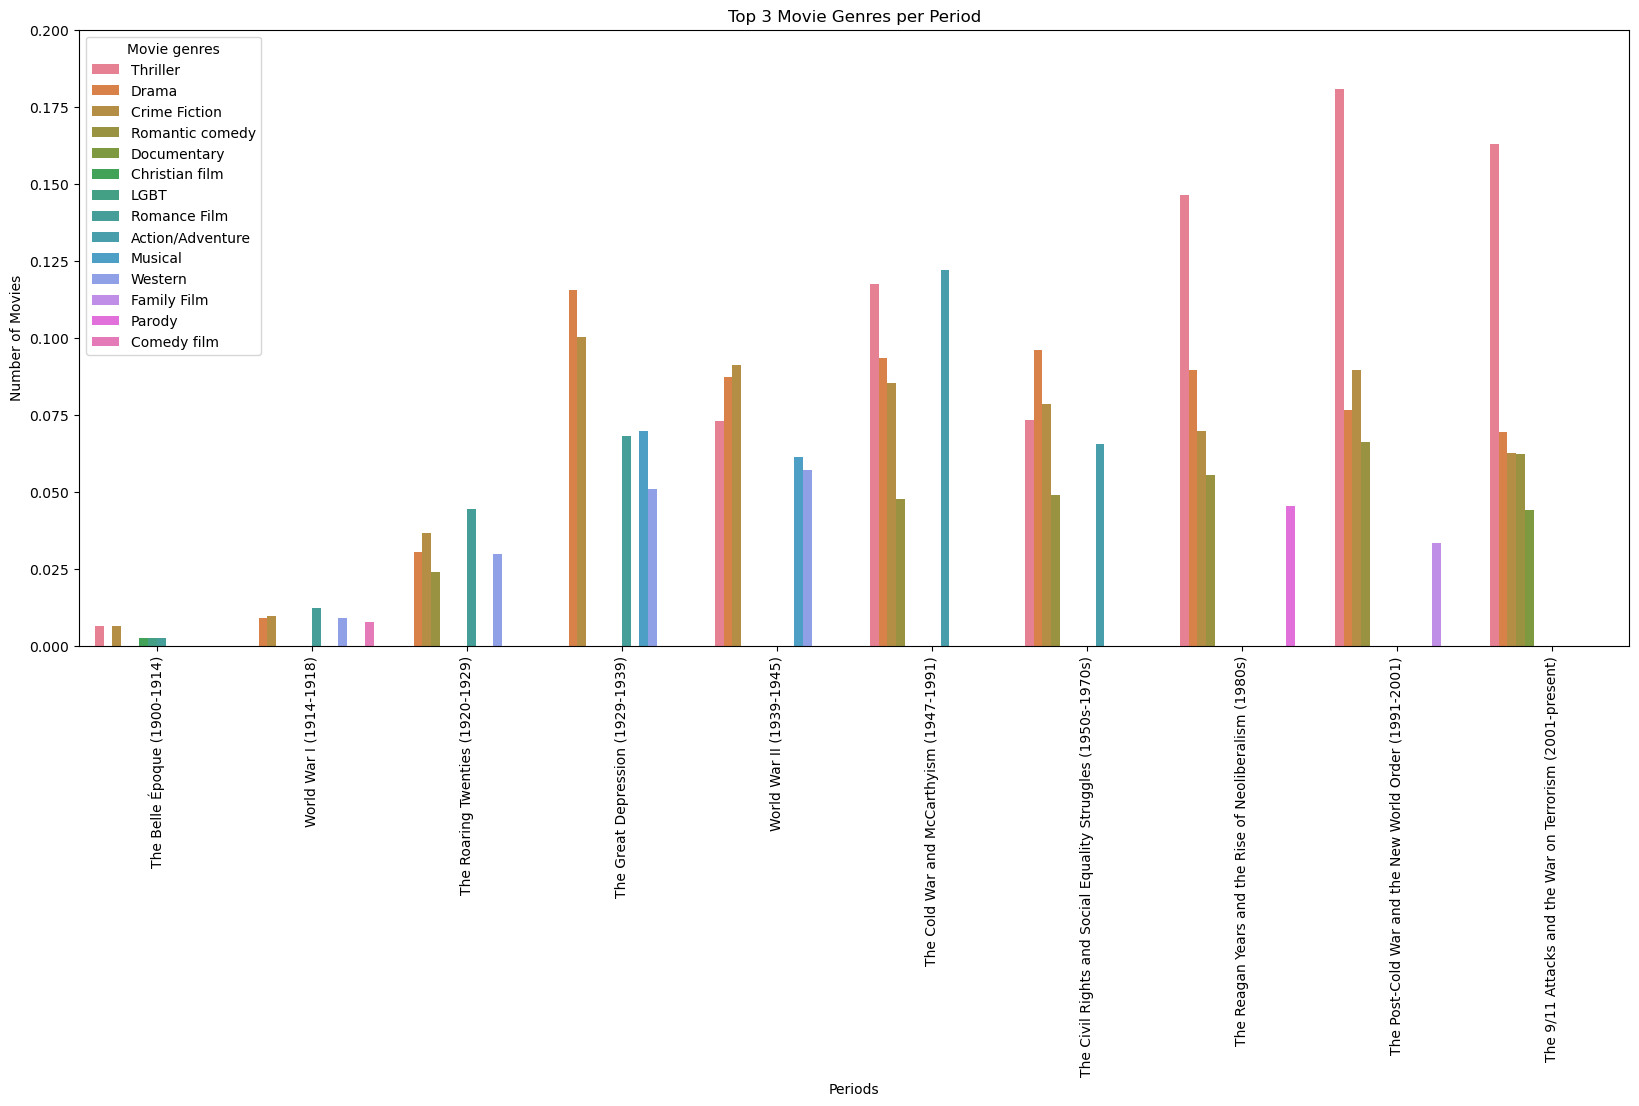

In [288]:
# Explode the 'Period' column to handle lists
movies_2df_exploded = movies_2df.explode('Period')

movies_2df_filtered = movies_2df_exploded[~movies_2df_exploded['Movie genres'].isin(unwanted_genres)]

# Group the movies by period and genre, and count the number of movies in each group
period_counts = movies_2df_filtered.groupby(['Period', 'Movie genres']).size().reset_index(name='count')
pc = movies_2df_exploded.groupby(['Period', 'Movie genres']).size().reset_index(name='count')

# Sort the counts in descending order for each period to get the top genres
period_counts_sorted = period_counts.sort_values(by=['Period', 'count'], ascending=[True, False])
pcs = pc.sort_values(by=['Period', 'count'], ascending=[True, False])

# Count the total number of movies in each period
#total_movies_per_period = period_counts_sorted.groupby('Period')['count'].transform('sum')
tot = pcs.groupby('Period')['count'].transform('sum')

# Normalize the counts by dividing each genre's count by the total number of movies in that period
period_counts_sorted['normalized_count'] = period_counts_sorted['count'] / tot #total_movies_per_period

# Extract the top 3 genres for each period
top_3_genres_per_period_normalized = period_counts_sorted.groupby('Period').head(5).reset_index(drop=True)


# You can also plot the top 3 genres for each period (optional)
plt.figure(figsize=(20, 8))
sns.barplot(data=top_3_genres_per_period_normalized, x='Period', y='normalized_count', hue='Movie genres', order=period_order_map)
plt.xlabel('Periods')
plt.ylabel('Number of Movies')
plt.title('Top 3 Movie Genres per Period')
plt.xticks(rotation=90)
plt.ylim(0, 0.2)
plt.show()

Period
The 9/11 Attacks and the War on Terrorism (2001-present)        8912.0
The Belle Époque (1900-1914)                                      30.0
The Civil Rights and Social Equality Struggles (1950s-1970s)    3721.0
The Cold War and McCarthyism (1947-1991)                        9877.0
The Great Depression (1929-1939)                                2409.0
The Post-Cold War and the New World Order (1991-2001)           5125.0
The Reagan Years and the Rise of Neoliberalism (1980s)          2969.0
The Roaring Twenties (1920-1929)                                 470.0
World War I (1914-1918)                                          113.0
World War II (1939-1945)                                        1919.0
dtype: float64
Period
The 9/11 Attacks and the War on Terrorism (2001-present)        0.989
The Belle Époque (1900-1914)                                    0.999
The Civil Rights and Social Equality Struggles (1950s-1970s)    1.007
The Cold War and McCarthyism (1947-1991)           

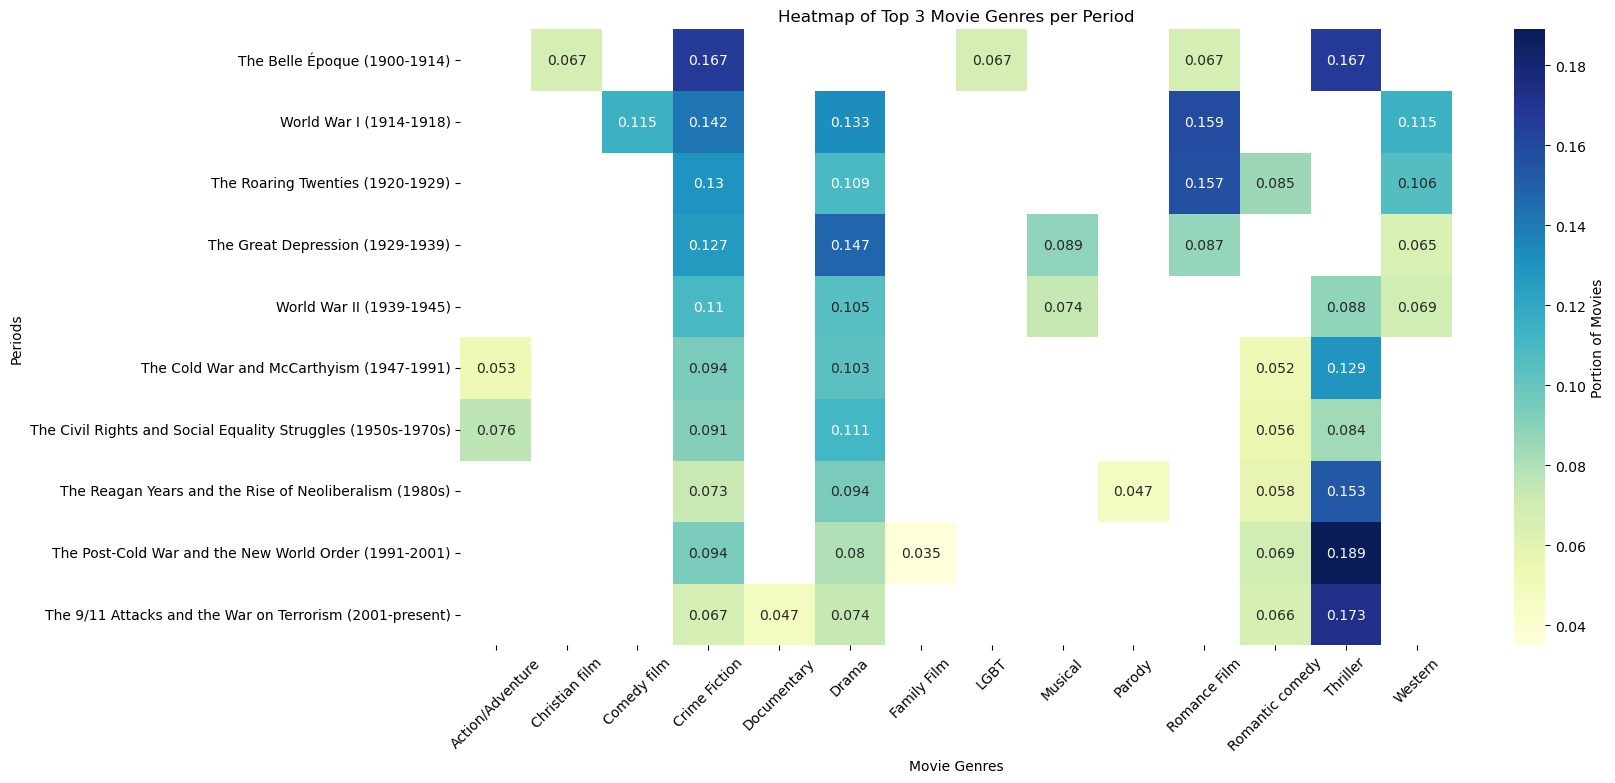

In [290]:
# Pivot the table to have periods as rows and genres as columns, with movie counts as values
period_counts_pivot = period_counts.pivot(index='Period', columns='Movie genres', values='count')

# Select top 3 genres for each period based on the count
top_genres_list = period_counts_pivot.apply(lambda x: x.nlargest(5).index, axis=1)

period_counts_pivot_normalized = period_counts_pivot.div(period_counts_pivot.sum(axis=1), axis=0)

# Round the values to 2 decimal places
period_counts_pivot_normalized = period_counts_pivot_normalized.round(3)

# Select top 3 genres for each period based on the count
top_genres_list = period_counts_pivot_normalized.apply(lambda x: x.nlargest(5).index, axis=1)

# Create a new DataFrame to store the counts for the top 3 genres per period
period_counts_pivot_top_3 = period_counts_pivot_normalized.apply(
    lambda x: x[top_genres_list.loc[x.name]], axis=1
)

# Order the periods based on the dictionary
ordered_periods = sorted(period_counts_pivot_top_3.index, key=lambda x: period_order_map.get(x, float('inf')))

# Reindex the DataFrame to match the order of periods in ordered_periods
period_counts_pivot_top_3 = period_counts_pivot_top_3.loc[ordered_periods]

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(period_counts_pivot_top_3, annot=True, fmt='g', cmap='YlGnBu', cbar_kws={'label': 'Portion of Movies'})
plt.title('Heatmap of Top 3 Movie Genres per Period')
plt.xlabel('Movie Genres')
plt.ylabel('Periods')
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Transpose the DataFrame so genres become rows and periods become columns
transposed_top_3 = period_counts_pivot_top_3.transpose()

# For each genre, select the top 3 periods with the highest values
top_3_genre_values = transposed_top_3.apply(lambda x: x.nlargest(3), axis=1)

# Print or examine the results
top_3_genre_values

In [ ]:
# barplot has no meaning here, it is just to display the 3 main or fewer periods for each main genre. 
# Loop through each genre to extract the top 3 periods with the highest score
for genre in period_counts_pivot_top_3.columns:
    # Get the corresponding values for the genre across all periods
    genre_data = period_counts_pivot_top_3[genre]
    
    # Count the number of NaN values for this genre
    nan_count = genre_data.count()

    # Get the top 3 periods with the highest values
    if nan_count < 3: 
        top_3_periods = genre_data.nlargest(nan_count)
    else: 
        top_3_periods = genre_data.nlargest(3)

    # Plot a bar chart for the top 3 periods for this genre
    plt.figure(figsize=(8, 4))
    top_3_periods.plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.title(f'Top 3 Periods for Genre: {genre}')
    plt.xlabel('Periods')
    plt.ylabel('Portion of Movies')
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [ ]:
# Prepare a list to store the data for all genres
all_genres_data = []

# Loop through each genre to extract the top 3 periods with the highest score
for genre in period_counts_pivot_top_3.columns:
    # Get the corresponding values for the genre across all periods
    genre_data = period_counts_pivot_top_3[genre]
    
    # Count the number of NaN values for this genre
    nan_count = genre_data.count()

    # Get the top 3 periods with the highest values
    if nan_count < 3: 
        top_3_periods = genre_data.nlargest(nan_count)
    else: 
        top_3_periods = genre_data.nlargest(3)

    # Prepare a list of themes for the top periods
    themes_for_top_periods = [periods_events_map[period] for period in top_3_periods.index]
    
    # Create the table with genre in one row, periods in another, and events in the last row
    table_data = {
        'Genre': [genre] * len(top_3_periods),
        'Periods': top_3_periods.index,
        'Events': ["; ".join(themes) for themes in themes_for_top_periods]
    }
    
    # Create a DataFrame for the genre
    genre_df = pd.DataFrame(table_data)
    
    # Append genre table data with empty row for separation
    all_genres_data.append(genre_df)
    all_genres_data.append(pd.DataFrame([['', '', '']], columns=['Genre', 'Periods', 'Events']))  # Empty row for separation

# Concatenate all the genre tables into one DataFrame
final_df = pd.concat(all_genres_data, ignore_index=True)

# Save the combined DataFrame to a CSV file
final_df.to_csv("All_Genres_Top_Periods.csv", index=False)

print("The data has been saved as a single CSV file.")

In [ ]:
# Function to calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Create a list of periods and their associated genres
periods = list(periods_events_map.keys())
period_genres = [set(periods_events_map[period]) for period in periods]

# Create a similarity matrix using the Jaccard similarity
similarity_matrix = np.zeros((len(periods), len(periods)))

for i, genres_1 in enumerate(period_genres):
    for j, genres_2 in enumerate(period_genres):
        if i != j:
            similarity_matrix[i, j] = jaccard_similarity(genres_1, genres_2)

# Convert the matrix to a DataFrame for easier visualization
similarity_df = pd.DataFrame(similarity_matrix, columns=periods, index=periods)

# Plotting the similarity matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap="YlGnBu", cbar=True, fmt=".2f", linewidths=0.5)
plt.title("Period Similarity Based on Shared Genres")
plt.xlabel("Periods")
plt.ylabel("Periods")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [64]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33163 entries, 0 to 74836
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Wikipedia movie ID        33163 non-null  int64  
 1   Freebase movie ID         33163 non-null  object 
 2   Movie name                33163 non-null  object 
 3   Movie release date        33163 non-null  int64  
 4   Movie box office revenue  6923 non-null   float64
 5   Movie runtime             29061 non-null  float64
 6   Movie languages           33163 non-null  object 
 7   Movie countries           33163 non-null  object 
 8   Movie genres              33163 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 2.5+ MB


In [65]:
movies_df.describe()

,Wikipedia movie ID,Movie release date,Movie box office revenue,Movie runtime
count,3.316300e+04,33163.000000,6.923000e+03,2.906100e+04
mean,1.350670e+07,1974.008926,5.461480e+07,1.253028e+02
std,1.039495e+07,30.923993,1.212461e+08,6.330756e+03
min,3.217000e+03,1901.000000,1.047400e+04,1.000000e+00
25%,4.033288e+06,1946.000000,2.400000e+06,7.700000e+01
50%,1.196696e+07,1984.000000,1.300000e+07,9.100000e+01
75%,2.207636e+07,2002.000000,4.980130e+07,1.020000e+02
max,3.750192e+07,2016.000000,2.782275e+09,1.079281e+06


In [66]:
print("percentage of NaNs per columns")
movies_df.isna().mean() * 100

percentage of NaNs per columns


Wikipedia movie ID           0.000000
Freebase movie ID            0.000000
Movie name                   0.000000
Movie release date           0.000000
Movie box office revenue    79.124325
Movie runtime               12.369207
Movie languages              0.000000
Movie countries              0.000000
Movie genres                 0.000000
dtype: float64

In [67]:
movies_df.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
72596,14746975,/m/03gwfh5,Creeps,1956,NaN,NaN,['English Language'],['United States of America'],"['Short Film', 'Comedy', 'Black-and-white']"
56854,28066589,/m/0cm8cy5,The Crimebusters,1962,NaN,88.0,['English Language'],['United States of America'],"['Crime Fiction', 'Drama']"
44400,17590117,/m/04653kt,Sentinels of Silence,1971,NaN,18.0,"['English Language', 'Spanish Language']","['Mexico', 'United States of America']","['Short Film', 'History', 'World History', 'Do..."
1220,24739648,/m/0806h15,Collapse,2009,NaN,82.0,['English Language'],['United States of America'],"['Political cinema', 'Indie', 'Documentary']"
36690,26743188,/m/0bmgw6w,Hit Man,1972,NaN,90.0,['English Language'],['United States of America'],"['Crime Fiction', 'Drama']"
53444,305909,/m/01shy7,Zoolander,2001,NaN,89.0,['English Language'],"['United States of America', 'Australia', 'Ger...","['Parody', 'Comedy of Errors', 'Comedy']"
14782,22410200,/m/05szdx6,Kerosene Cowboys,2010,NaN,100.0,[],['United States of America'],"['Thriller', 'Action']"
52929,10320328,/m/02q8byd,Those She Left Behind,1989,NaN,96.0,['English Language'],['United States of America'],['Drama']
38496,19911954,/m/04q2rwr,Novel Romance,2005,NaN,92.0,['English Language'],['United States of America'],"['Romantic comedy', 'Romance Film', 'Indie', '..."
9806,471370,/m/02dj5n,An American Werewolf in London,1981,61973249.0,92.0,['English Language'],"['United States of America', 'United Kingdom']","['Fantasy', 'Horror', 'Creature Film', 'Horror..."


In [73]:
def get_genre(string):
    try:
        return string.str.split('"')[3]
    except:
        return "No genre"

genres = movies_df["Movie genres (Freebase ID:name tuples)"].apply(get_genre).value_counts().head(50)
plt.figure(figsize=(14,3))
plt.xlabel("genre")
plt.ylabel("count")
genres.plot(kind="bar")

KeyError: 'Movie genres (Freebase ID:name tuples)'

<Axes: title={'center': 'Top 4 genre per year'}, xlabel='Movie release year'>

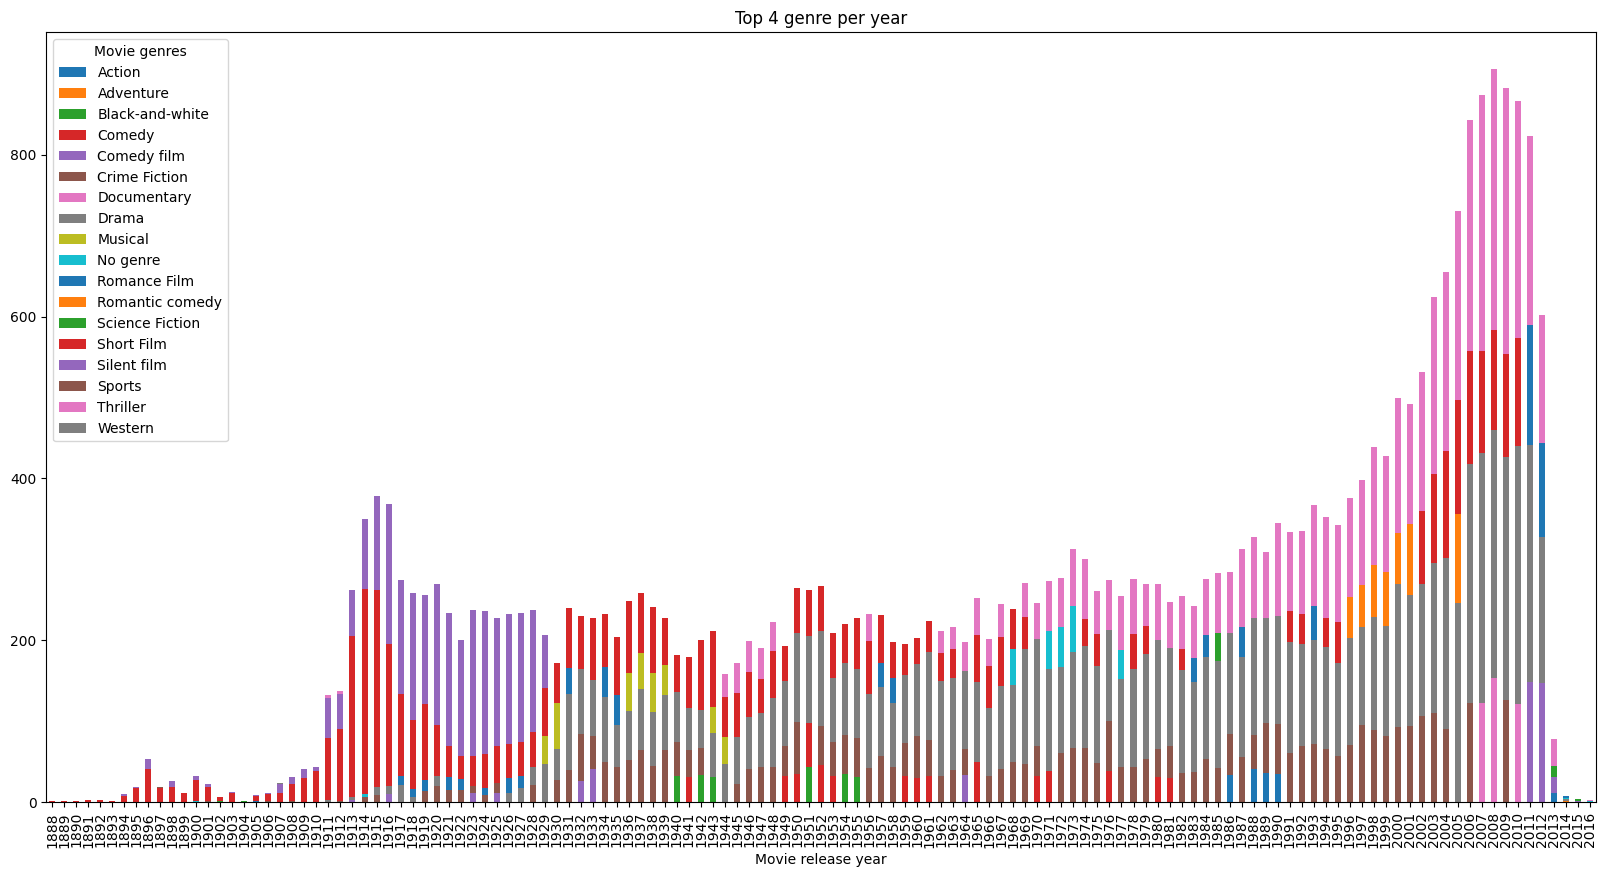

In [50]:
genre_counts = movies_df.copy(deep=True)
def get_year(string):
    try: return string.split("-")[0]
    except: return ""
genre_counts["Movie release year"] =pd.to_datetime(genre_counts['Movie release date'], errors='coerce').dt.year.astype('Int64')
#genre_counts["Movie release date"].apply(get_year)
genre_counts["Movie genres"] = genre_counts["Movie genres (Freebase ID:name tuples)"].apply(get_genre)

genre_counts = genre_counts.groupby(["Movie release year", "Movie genres"]).size().unstack(fill_value=0)

genre_counts.apply(lambda x: x.nlargest(4), axis=1).plot(kind="bar", stacked=True, figsize=(20, 10),
                                                         title="Top 4 genre per year")
#plt.xlim(1910,2011)

<Axes: title={'center': 'Normalized genre distribution per year'}, xlabel='Movie release year'>

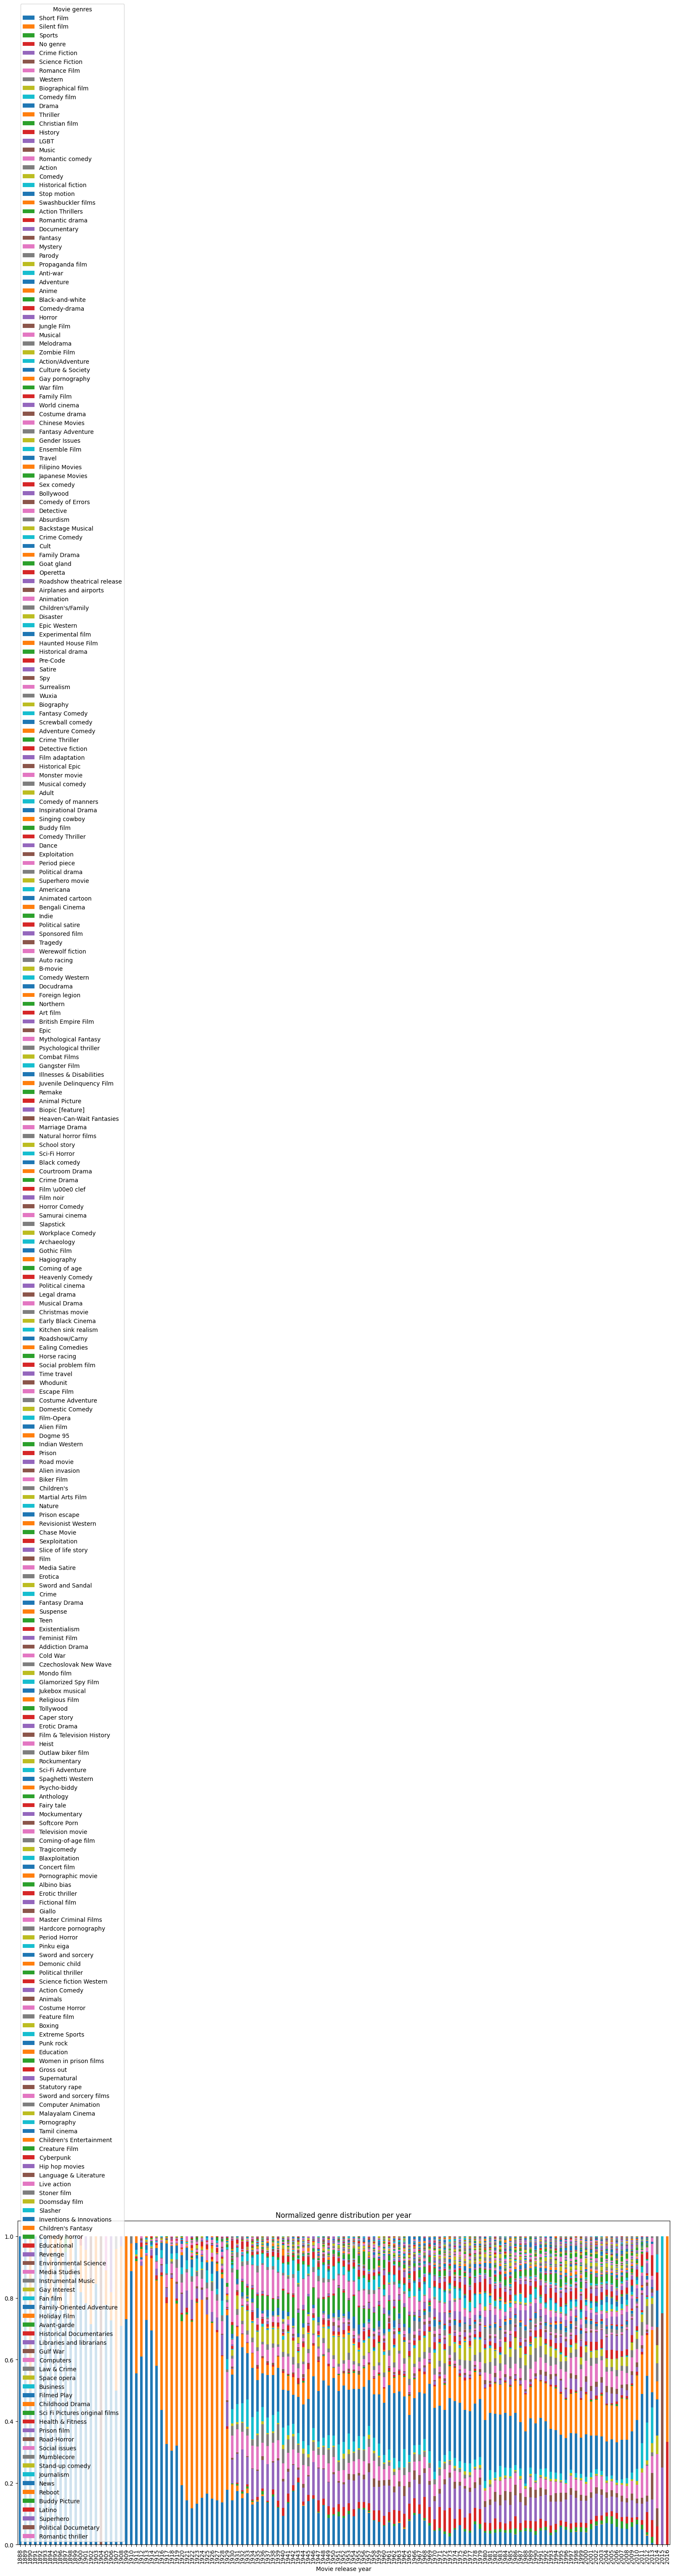

In [49]:
genre_counts.div(genre_counts.sum(axis=1), axis=0).plot(kind="bar", stacked=True, figsize=(20, 10),title="Normalized genre distribution per year")

<Axes: xlabel='country', ylabel='count'>

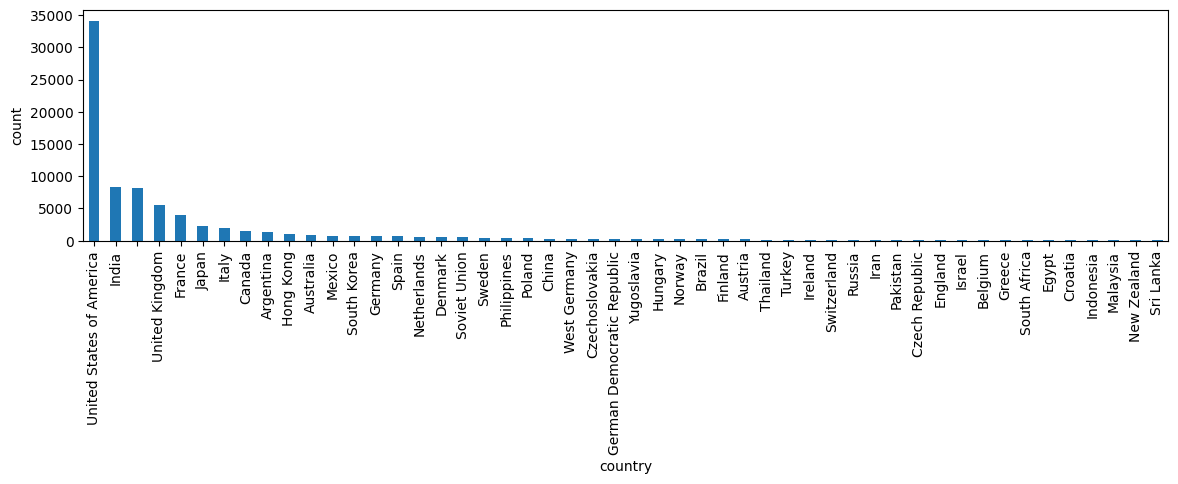

In [140]:
countries = movies_df["Movie countries (Freebase ID:name tuples)"].apply(get_genre).value_counts().head(50)
plt.figure(figsize=(14,3))
plt.xlabel("country")
plt.ylabel("count")
countries.plot(kind="bar")

<Axes: xlabel='language', ylabel='count'>

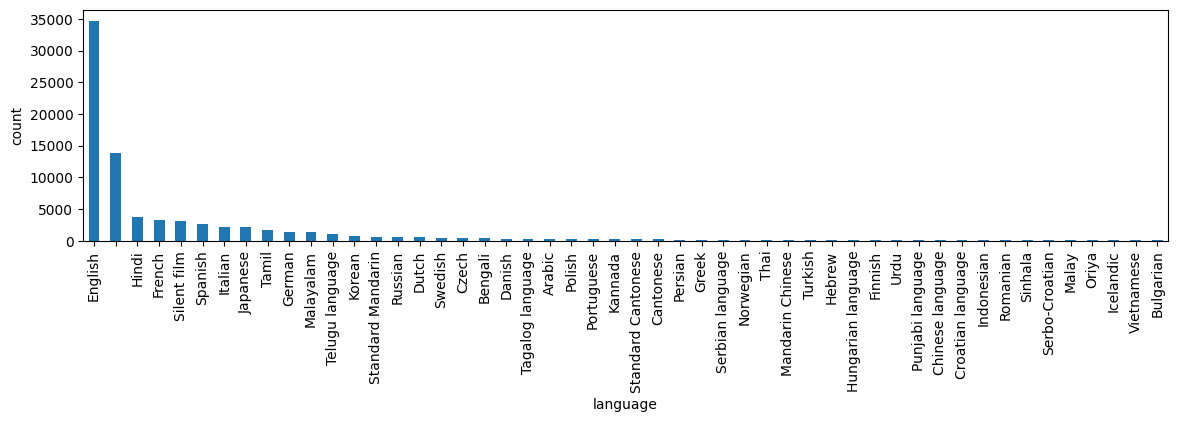

In [141]:
def get_language(string):
    try:
        return string.split('"')[3].replace("Language", "").strip()
    except:
        return ""

languages = movies_df["Movie languages (Freebase ID:name tuples)"].apply(get_language).value_counts().head(50)
plt.figure(figsize=(14,3))
plt.xlabel("language")
plt.ylabel("count")
languages.plot(kind="bar")

<Axes: title={'center': 'Movie box office revenue distribution'}, xlabel='Movie box office revenue', ylabel='frequency'>

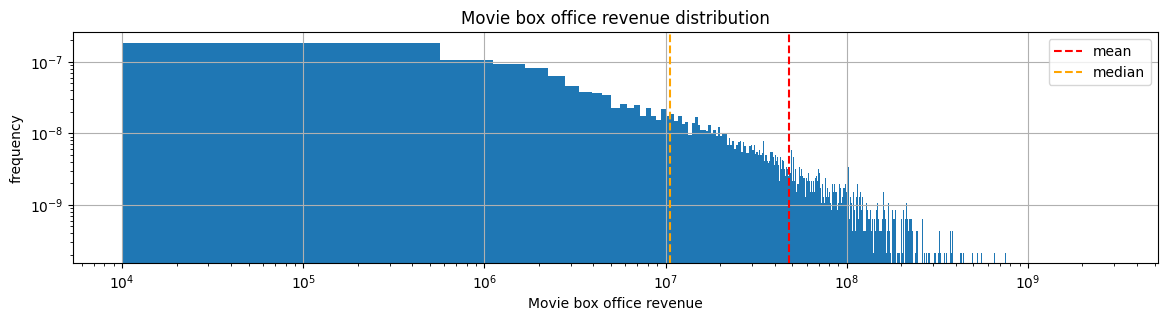

In [142]:
plt.figure(figsize=(14,3))
plt.title("Movie box office revenue distribution")
plt.xlabel("Movie box office revenue")
plt.ylabel("frequency")
#plt.xlim(0, 100000000)
plt.xscale("log")
plt.yscale("log")
plt.axvline(movies_df["Movie box office revenue"].mean(), color="red", label="mean", linestyle="--")
plt.axvline(movies_df["Movie box office revenue"].median(), color="orange", label="median", linestyle="--")
plt.legend()
movies_df["Movie box office revenue"].hist(density=True, bins=5000)

In [147]:
print("Top 50 films with the highest movie box office revenue")
movies_df.sort_values(ascending=False, by="Movie box office revenue")[["Movie name", "Movie release date", "Movie box office revenue"]].head(50)

Top 50 films with the highest movie box office revenue


,Movie name,Movie release date,Movie box office revenue
23702,Avatar,2009-12-10,2 782 275 172
22256,Titanic,1997-11-01,2 185 372 302
28192,The Avengers,2012-04-11,1 511 757 910
30278,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1 328 111 219
18645,Transformers: Dark of the Moon,2011-06-23,1 123 746 996
80920,The Lord of the Rings: The Return of the King,2003-12-17,1 119 929 521
54719,The Dark Knight Rises,2012-07-16,1 078 008 948
69586,Toy Story 3,2010-06-12,1 063 171 911
14303,Pirates of the Caribbean: On Stranger Tides,2011-05-07,1 043 871 802
50039,Star Wars Episode I: The Phantom Menace,1999-05-19,1 027 044 677
